<a href="https://colab.research.google.com/github/rlawogjs96/deeplearning_paper_reviews/blob/main/Learning_Phrase_Representations_using_RNN_Encoder_Decoder_for_Statistical_Machine_Learning_(STM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Learning (STM)**



논문을 바탕으로 Seq2Seq 아키텍쳐와 LSTM의 대한책인 Gated Recurrent Unit(GRU)를 구현했다. 들어가기에 앞서 RNN Encoder-Decoder, GRU, STM이 무엇인지 학습하고 들어가보겠다. Encoder는 가변 길이의 source sequence를 고정된 크기의 context vector로 만드는 역할을 갖고 있고, Decoder는 context vector를 다시 가변 길이의 target sequence로 변환하는 역할을 갖는다. 이렇게 RNN Encoder-Decoder는 인코더와 디코더 역할을 갖는 두 개의 RNN을 바탕으로 만들어졌다. GRU 모델에서는 hidden state이 불필요한 정보를 알아서 무시하고 더 함축된 representation을 생성할 수 있다. Reset Gate와 Update Gate이 존재하고, Reset Gate이 0에 가까워 지면 이전 hidden state값이 무시되고 현재의 input만이 hidden state에 영향을 준다. 또한 Update Gate은 current hidden state으로 얼마나 많은 정보를 업데이트할지 결정하는 역할을 갖고있다. 

### Introduction
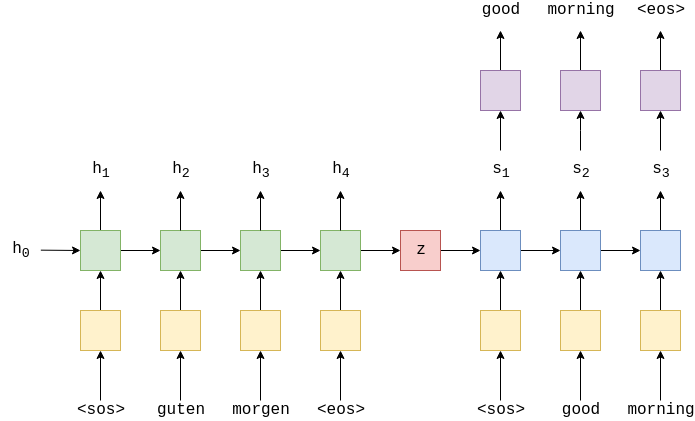

The context vector (red) created by the encoders (green) are used with the decoder (blue) along with a linear layer (purple) in order to generate the target sentence. This is the general encoder-decoder model. 

The **RNN Encoder-Decoder** is made up of two Recurrent Neural Networks (RNN). Each RNN plays a role of an encoder and a decoder. 
1.   **Encoder:** Encodes a sequence of symbols into a fixed length vector representation. Maps a variable-length source sequence to a fixed-length vector. 
2.   **Decoder:** Decodes the representation into another sequence of symbols. Maps the vector representation back to a variable-length target sequence.
*   Both the Encoder & Decoder are trained to **maximize** the conditional probability of a target sequence given a source sequence. The model is used in an SMT to improve translation performance. 






The **GRU (Gated Recurrent Unit)** replaces the LSTM (Long Short-Term Memory) model. Hidden state can now eliminate irrelevant information to create a more compact representation. Update gate controls how much information from previous hidden state will be brought into current hidden state. 

# **1. Preparing Data**

In [ ]:
!apt install python 3.7
!pip install -U torchtext==0.6.0
!python -m spacy download en 
!python -m spacy download de

In [ ]:
import torch 
import torch.nn as nn 
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math 
import time 

# Set random seed for deterministic results
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# Instantiate German / English spacy models
spacy_en = spacy.load('en_core_web_sm')
spacy_de = spacy.load('de_core_news_sm')

**Tokenizers**

Tokenizers help transform a sentence into tokens. 
  i.e.) "Hello World!" --> ["Hello", "World", "!"]




In [ ]:
def tokenize_de(text): 
  # Tokenizes German text from string into a list of strings 
  return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text): 
  # Tokenizes English text from string into a list of strings 
  return [tok.text for tok in spacy_en.tokenizer(text)]

Fields will append "start of sentence (sos)" and "end of sentence (eos)" tokens and convert all words into lower case.

In [ ]:
SRC = Field(tokenize= tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize= tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

Multi30k dataset contains 30k English, German, French sentences, each sentence consist of 12 words. 

In [ ]:
# Load Data
train_data, valid_data, test_data = Multi30k.splits(exts= ('.de', '.en'),
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 751kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 233kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 214kB/s]


In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [ ]:
print(len(vars(train_data.examples[0])['src']))
print(len(vars(train_data.examples[1])['src']))

print(vars(train_data.examples[0]))
print(vars(train_data.examples[1]))

13
8
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
{'src': ['mehrere', 'männer', 'mit', 'schutzhelmen', 'bedienen', 'ein', 'antriebsradsystem', '.'], 'trg': ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']}


Create vocabulary and convert all tokens that appear less than twice into unknown tokens.

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


In [ ]:
# Define device, create iterators
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device
)

# **2. Seq2Seq Model**
**Encoder**

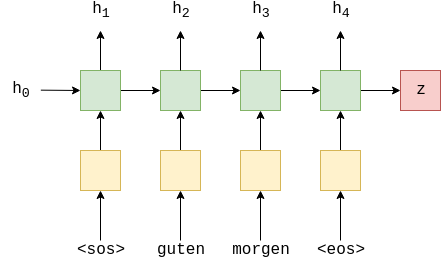

*   The Encoder consists of 1 single GRU layer. Unlike LSTM, we do not pass the dropout as an argument to the GRU, because it is used between each layer in RNN. 
*   In GRU, unlike LSTM, the cell state is not used as an input / output for the RNN network.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim  
        self.embedding = nn.Embedding(input_dim, emb_dim) # no dropout as only one layer!
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        # src = [src len, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src len, batch size, emb dim]
        outputs, hidden = self.rnn(embedded) #no cell state!
        # outputs = [src len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
  
        # outputs are always from the top hidden layer
        
        return hidden

**Decoder**
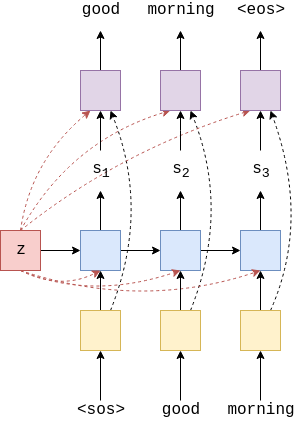

*   Input dimension of GRU is emb_dim + hid_dim (context vector will be the size of hid_dim) 
*   Input dimension for final output will be emb_dim + hid_dim * 2

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, context):
        
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hid dim]
        # context = [n layers * n directions, batch size, hid dim]
        
        # n layers and n directions in the decoder will both always be 1, therefore:
        # hidden = [1, batch size, hid dim]
        # context = [1, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        # input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        # embedded = [1, batch size, emb dim]
                
        emb_con = torch.cat((embedded, context), dim = 2)
            
        # emb_con = [1, batch size, emb dim + hid dim]
            
        output, hidden = self.rnn(emb_con, hidden)
        
        # output = [seq len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        
        # seq len, n layers and n directions will always be 1 in the decoder, therefore:
        # output = [1, batch size, hid dim]
        # hidden = [1, batch size, hid dim]
        
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), 
                           dim = 1)
        
        # output = [batch size, emb dim + hid dim * 2]
        
        prediction = self.fc_out(output)
        
        # prediction = [batch size, output dim]
        
        return prediction, hidden

**Seq2Seq Model**
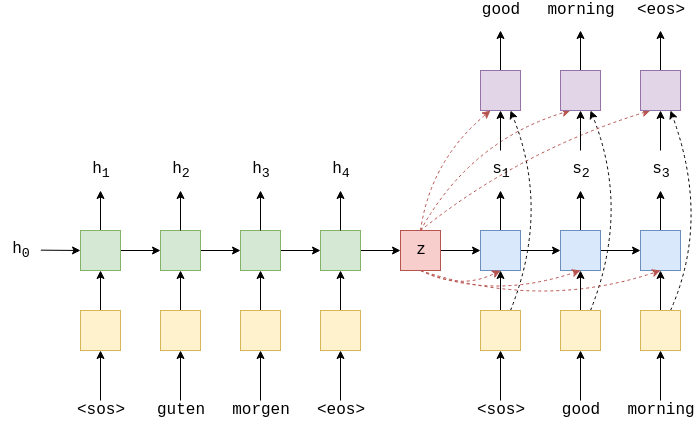

*   The source sentence is fed into the encoder to receive a context vector. 
*   The initial decoder hidden state is the context vector. 
*   We put the context vector into the decoder in order to predict the target(output) sentence.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        # src = [src len, batch size]
        # trg = [trg len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is the context
        context = self.encoder(src)
        
        # context also used as the initial hidden state of the decoder
        hidden = context
        
        # first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            # insert input token embedding, previous hidden state and the context state
            # receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, context)
            
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

Initialize encoder, decoder and seq2seq model. Hidden dimensions remain the same.

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

Initialize parameters which are initialized from a normal distribution with mean of 0 and standard deviation of 0.01. 

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Print the number of parameters. 

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters.')

The model has 14,219,781 trainable parameters.


Initialize optimizer.

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Define training loop.

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        # trg = [trg len, batch size]
        # output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        # trg = [(trg len - 1) * batch size]
        # output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Define evaluation loop.

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) # turn off teacher forcing

            # trg = [trg len, batch size]
            # output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            # trg = [(trg len - 1) * batch size]
            # output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Calculate how long an epoch takes.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Train the model, saving parameters that give us best validation loss.

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 37s
	Train Loss: 5.052 | Train PPL: 156.394
	 Val. Loss: 5.135 |  Val. PPL: 169.933
Epoch: 02 | Time: 0m 36s
	Train Loss: 4.383 | Train PPL:  80.083
	 Val. Loss: 5.350 |  Val. PPL: 210.709
Epoch: 03 | Time: 0m 36s
	Train Loss: 4.094 | Train PPL:  59.955
	 Val. Loss: 4.785 |  Val. PPL: 119.744
Epoch: 04 | Time: 0m 36s
	Train Loss: 3.772 | Train PPL:  43.465
	 Val. Loss: 4.505 |  Val. PPL:  90.428
Epoch: 05 | Time: 0m 36s
	Train Loss: 3.455 | Train PPL:  31.661
	 Val. Loss: 4.267 |  Val. PPL:  71.318
Epoch: 06 | Time: 0m 36s
	Train Loss: 3.171 | Train PPL:  23.833
	 Val. Loss: 4.023 |  Val. PPL:  55.880
Epoch: 07 | Time: 0m 35s
	Train Loss: 2.919 | Train PPL:  18.530
	 Val. Loss: 3.841 |  Val. PPL:  46.568
Epoch: 08 | Time: 0m 36s
	Train Loss: 2.673 | Train PPL:  14.478
	 Val. Loss: 3.689 |  Val. PPL:  39.990
Epoch: 09 | Time: 0m 36s
	Train Loss: 2.445 | Train PPL:  11.529
	 Val. Loss: 3.675 |  Val. PPL:  39.446
Epoch: 10 | Time: 0m 36s
	Train Loss: 2.271 | Train PPL

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.605 | Test PPL:  36.770 |
